In [1]:
import sys
sys.path.insert(0, '../scripts')

In [2]:
# Remove warnings for anonymization of the paper
import warnings
warnings.warn = lambda *args, **kwargs: None
# ------------------------------------------

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14, 'legend.frameon': False})

import torch
from torch import nn

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from dcg.graph import CausalGraph
from dcg.flow import NCF
from dcg.distributional.discrete import Bernoulli
from dcg.latents import LatentNormal
from dcg.training import *

from utils import path

In [3]:
load = True

In [4]:
np.random.seed(123)
torch.manual_seed(1234)

In [5]:
with open(path('../data/salary/definition.json')) as f:
    definition = f.read()

_train = pd.read_csv(path('../data/salary/train.csv'))
test = pd.read_csv(path('../data/salary/test.csv'))

In [6]:
split = .8
n = int(len(_train) * split)

trainX = torch.Tensor(_train.astype(float).values)
testX = torch.Tensor(test.astype(float).values)

trainX, valX = trainX[:n], trainX[n:]

In [7]:
device = get_device()

graph = CausalGraph.from_definition(
    CausalGraph.parse_definition(
        definition,
        lat=LatentNormal,
        bern=Bernoulli,
        cont=NCF
    ),
    node_kwargs=dict(salary=dict(head_parents=['gender']))
).to(device)

if not load:
    plot_losses(*train(graph, trainX, valX, batch_size=128, patience=100))

Training took 17 mins, 55s, with 429 epochs total.

In [8]:
model_path = path('../models/salary.pt')

if not load:
    torch.save(graph.state_dict(), model_path)
else:
    graph.load_state_dict(torch.load(model_path))
    graph.eval()

In [9]:
# Reset again, since we could have loaded the model instead of training
np.random.seed(123)
torch.manual_seed(1234)

In [10]:
with torch.no_grad():
    print('Train nll:', graph.nll(trainX.to(device)).mean().item())
    print('Validation nll:', graph.nll(valX.to(device)).mean().item())
    print('Test nll:', graph.nll(testX.to(device)).mean().item())

Train nll: 9.264262199401855
Validation nll: 9.295271873474121
Test nll: 9.22657585144043


# Utility functions

In [11]:
def ci(x):
    x = np.array(x)
    m, s = x.mean(), 1.96 * x.std() / np.sqrt(len(x))
    
    return '%.3f +- %.3f' % (m, s)

In [12]:
def plot_ci(x, m, s, color=None, alpha=.25, ax=None, **plot_kwargs):
    if ax is None: ax = plt.gca()
        
    ax.plot(x, m, color=color, **plot_kwargs)
    ax.fill_between(x, m - s, m + s, color=color, alpha=alpha)

In [13]:
def plot_xdistr(x, ax=None, alpha=.5):
    if ax is None: ax = plt.gca()
        
    m, M = ax.get_ylim()
    ax.scatter(x, np.full_like(x, m), marker='|', c='k', s=100, alpha=alpha)
    ax.set_ylim((m, M))

# Dataset analysis

We don't use this analysis in the paper since we're focusing on studying a black-box predictor, but we leave it here as an example.

In [14]:
# p(salary | do(gender))
REPL = 100

results = []
for _ in range(REPL):
    with torch.no_grad():
        y1 = graph.sample(1000, 'salary', dict(gender=True)).flatten().cpu().numpy()
        y0 = graph.sample(1000, 'salary', dict(gender=False)).flatten().cpu().numpy()
    
    results.append(y1.mean() - y0.mean())
    
ci(results)

'4107.492 +- 37.928'

In [15]:
# p(salary | gender)
_train.groupby('gender').salary.mean().diff().iloc[1]

5238.734477921844

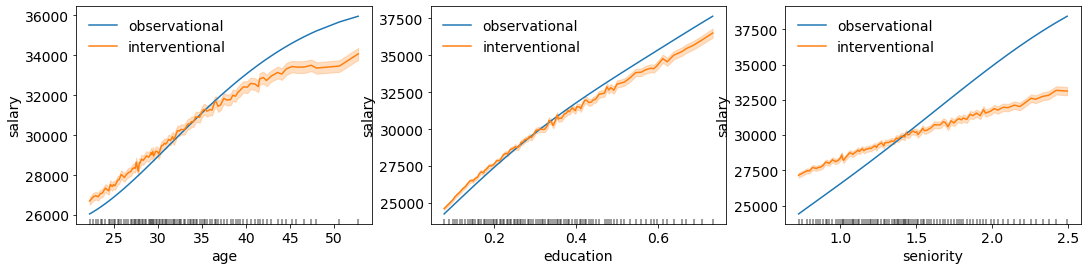

In [16]:
nodes = ['age', 'education', 'seniority']
n = len(nodes)
_, axes = plt.subplots(1, n, figsize=(6 * n, 4))

for ax, node in zip(axes, nodes):
    # p(salary | do(node)) vs p(salary | node)
    N = 100
    EX_N = 1000

    # First, determine N points for age appropriate for its distribution
    with torch.no_grad():
        x = graph.sample(N * 10, node).flatten().cpu().numpy()
        x = pd.Series(x).quantile(np.linspace(.025, .975, N)).values

    # Observational: use LinearRegression with 5-degree polynomial features
    obs = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(5),
        LinearRegression()
    ).fit(_train[[node]], _train.salary).predict(x[:, np.newaxis])

    # Interventional: compute samples for each intervention
    with torch.no_grad():
        sample = graph.sample(EX_N * N, 'salary', {node: x}).view(EX_N, N).cpu().numpy()
        m, s = sample.mean(0), 1.96 * sample.std(0) / np.sqrt(EX_N)

    # Plot them together
    ax.plot(x, obs, label='observational')
    plot_ci(x, m, s, label='interventional', color='C1', ax=ax)
    plot_xdistr(x, ax=ax)
    ax.legend()
    ax.set_xlabel(node)
    ax.set_ylabel('salary')

# Train regressor

In [17]:
import torch
from torch import nn, optim

In [18]:
trainX = torch.Tensor(_train.drop('salary', 1).astype(float).values).to(device)
trainY = torch.Tensor(_train.salary.values).to(device)
split = int(len(trainX) * .8)
trainX, valX = trainX[:split], trainX[split:]
trainY, valY = trainY[:split], trainY[split:]
testX = torch.Tensor(test.drop('salary', 1).astype(float).values).to(device)
testY = torch.Tensor(test.salary.values).to(device)

In [19]:
def train(trainX, trainY, valX, valY, n_epochs=25, batch_size=128, reg=None, lr=1e-2, l2=1e-3):
    N, NCOL = trainX.shape

    class Model(nn.Sequential):
        
        def __init__(self, X, Y):
            super().__init__(
                nn.Linear(NCOL, 100),
                nn.ReLU(),
                nn.Linear(100, 50),
                nn.ReLU(),
                nn.Linear(50, 1)
            )
            
            self.register_buffer('_input_mean', X.mean(0))
            self.register_buffer('_input_scale', X.std(0))
            self[-1].weight.data *= trainY.std(0)
            self[-1].bias.data *= trainY.mean(0)
            
        def forward(self, x):
            x = (x - self._input_mean) / self._input_scale
            return super().forward(x)
        
        def _to_tensor(self, X):
            if isinstance(X, pd.DataFrame):
                X = X.values

            if isinstance(X, np.ndarray):
                X = torch.Tensor(X.astype(float)).to(device)

            return X

        def predict(self, X):
            with torch.no_grad():
                X = self._to_tensor(X)
                return self(X).cpu().numpy().flatten()

            
    model = Model(trainX, trainY).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    
    best_model = None
    best_loss = float('inf')
    best_epoch = -1

    train_losses, train_reg_losses = [], []
    val_losses, val_reg_losses = [], []
    for epoch in tqdm(range(1, n_epochs + 1)):
        model.train()
        idx = torch.randperm(N, device=device)
        for n in range(0, N, batch_size):
            if N - n < 2: continue
            X = trainX[idx[n:n+batch_size]]
            Y = trainY[idx[n:n+batch_size]].view(-1, 1)

            pred = model(X)
            loss = ((pred - Y) ** 2).mean()
            train_losses.append((epoch - 1, loss.item()))
            
            if reg is not None:
                reg_loss = reg(model, X, Y).mean()
                train_reg_losses.append((epoch, reg_loss.item()))
                
                loss = loss + reg_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss, val_reg_loss = 0, 0
            for n in range(0, len(valX), batch_size):
                X = valX[n:n+batch_size]
                Y = valY[n:n+batch_size]

                pred = model(X)
                val_loss += (((pred - Y) ** 2).sum() / len(valX)).item()

                if reg is not None:
                    val_reg_loss += reg(model, X, Y).sum().item() / len(valX)

        val_losses.append((epoch, val_loss))
        if reg is not None:
            val_reg_losses.append((epoch, val_reg_loss))
            
        loss = val_loss
        if reg is not None:
            loss += val_reg_loss
        
        if loss < best_loss:
            best_loss = loss
            best_model = { k: v.clone() for k, v in model.state_dict().items() }
            best_epoch = epoch
            
    model.load_state_dict(best_model)
    model.eval()

    train_losses = pd.DataFrame(train_losses, columns=['epoch', 'loss'])
    val_losses = pd.DataFrame(val_losses, columns=['epoch', 'loss'])
    train_reg_losses = pd.DataFrame(train_reg_losses, columns=['epoch', 'loss'])
    val_reg_losses = pd.DataFrame(val_reg_losses, columns=['epoch', 'loss'])
    
    nc = 1 + (reg is not None)
    _, axes = plt.subplots(1, nc, figsize=(6 * nc, 4 * 1), squeeze=False)
    axes = axes.flatten()

    train_losses.epoch = train_losses.groupby('epoch').apply(
        lambda x: pd.Series(np.linspace(0, 1, len(x) + 1)[:-1] + x.name, index=x.index)
    ).reset_index(drop=True)
    
    if reg is not None:
        train_reg_losses.epoch = train_reg_losses.groupby('epoch').apply(
            lambda x: pd.Series(np.linspace(0, 1, len(x) + 1)[:-1] + x.name, index=x.index)
        ).reset_index(drop=True)

    train_losses.plot('epoch', 'loss', label='train', legend=True, ax=axes[0])
    val_losses.plot('epoch', 'loss', label='validation', legend=True, ax=axes[0])
    axes[0].set_ylabel('loss');
    
    if reg is not None:
        train_reg_losses.plot('epoch', 'loss', label='train', legend=True, ax=axes[1])
        val_reg_losses.plot('epoch', 'loss', label='validation', legend=True, ax=axes[1])
        axes[1].set_ylabel('loss');
        
    for ax in axes:
        ax.axvline(best_epoch, ls='--', color='gray')
    
    return model

In [20]:
model = train(trainX, trainY, valX, valY, n_epochs=100, lr=1e-2)

100%|██████████| 100/100 [00:04<00:00, 22.80it/s]


In [21]:
ytrue = test.salary
pred = model.predict(test.drop('salary', 1))

plt.scatter(ytrue, pred, alpha=.1)
plt.xlabel('salary')
plt.ylabel('prediction')
m, M = min(ytrue.min(), pred.min()), max(ytrue.max(), pred.max())
plt.plot([m, M], [m, M], ls='--', color='gray')

# R2
metrics.r2_score(ytrue, pred)

0.9848089078367231

Does it correctly adjust the gender gap?

In [22]:
pd.DataFrame({'salary': pred, 'gender': test.gender}).groupby('gender').salary.mean()

gender
False    27848.451172
True     32807.859375
Name: salary, dtype: float32

In [23]:
test.groupby('gender').salary.mean()

gender
False    27759.248675
True     32884.905750
Name: salary, dtype: float64

It underestimates high salaries (salary is highly skewed), which affects the gender gap. Nevertheless, we're only interested in explaining the predictor, not the original dataset, so we'll focus on that.

# Interpretability

We'll intervene on gender, field, age and education. Note that gender and age would be root nodes if there were no latent confounder. Were they root nodes, then there would be no difference between the intervened and observational distributions; in our case, since there is a confounder, this is not true, but we'll see that its effect is not exceptionally significant anyway (the confounder doesn't affect that much).

In [24]:
with torch.no_grad():
    obs_sample = graph.sample(2000)
    
    obs_sample = pd.DataFrame(obs_sample.cpu().numpy(), columns=_train.columns)
    obs_sample.gender = obs_sample.gender > .5
    obs_sample.field = obs_sample.field > .5
    obs_pred = pd.Series(model.predict(obs_sample.drop('salary', 1)), index=obs_sample.index)

In [25]:
with torch.no_grad():
    male = graph.sample(1000, interventions={'gender': True})
    female = graph.sample(1000, interventions={'gender': False})
    
    sample = pd.concat([
        pd.DataFrame(x.cpu().numpy(), columns=_train.columns) 
        for x in [male, female]
    ])
    
    sample.gender = sample.gender > .5
    
    pred = pd.Series(model.predict(sample.drop('salary', 1)), index=sample.index)
    
pred.groupby(sample.gender).apply(ci), \
obs_pred.groupby(obs_sample.gender).apply(ci)

(gender
 False    28682.027 +- 236.691
 True     32231.455 +- 279.470
 dtype: object,
 gender
 False    28011.289 +- 196.972
 True     32889.043 +- 306.895
 dtype: object)

If we try with field:

In [26]:
with torch.no_grad():
    field_b = graph.sample(1000, interventions={'field': True})
    field_a = graph.sample(1000, interventions={'field': False})
    
    sample = pd.concat([
        pd.DataFrame(x.cpu().numpy(), columns=_train.columns) 
        for x in [field_b, field_a]
    ])
    sample.field = sample.field > .5
    
    pred = pd.Series(model.predict(sample.drop('salary', 1)), index=sample.index)
    
pred.groupby(sample.field).apply(ci), \
obs_pred.groupby(obs_sample.field).apply(ci)

(field
 False    27918.984 +- 179.520
 True     32390.172 +- 273.975
 dtype: object,
 field
 False    27348.344 +- 154.532
 True     33306.367 +- 284.671
 dtype: object)

Continuous interventions:

Note how for every different intervention, we need to train a different model (with a different statistical estimand) to answer the query using do-calculus. Our model, instead, allows us to answer all queries with one single training. 

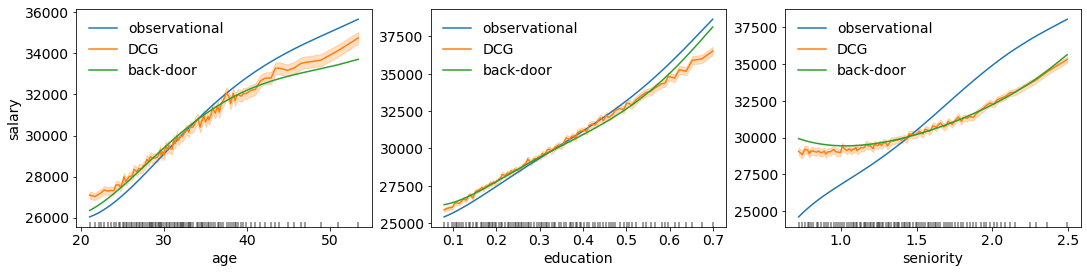

In [27]:
# p(salary | do(X)) vs p(salary | X)
N = 100
EX_N = 1000

nodes = ['age', 'education', 'seniority']
admissible_set = {
    'age': {'gender'},
    'education': {'age'},
    'seniority': {'education', 'age', 'gender', 'field'}
}

n = len(nodes)
_, axes = plt.subplots(1, n, figsize=(6 * n, 4))

for ax, xname in zip(axes, nodes):
    # First, determine N points for X appropriate for its distribution
    with torch.no_grad():
        x = graph.sample(N * 10, xname).flatten().cpu().numpy()
        x = pd.Series(x).quantile(np.linspace(.025, .975, N)).values

    # Observational: use LinearRegression with 5-degree polynomial features
    obs = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(5),
        LinearRegression()
    ).fit(test[[xname]], model.predict(test.drop('salary', 1))).predict(x[:, np.newaxis])

    # Interventional: compute samples for each intervention
    with torch.no_grad():
        sample = graph.sample(EX_N * N, interventions={xname: x})
        sample = pd.DataFrame(sample.cpu().numpy(), columns=_train.columns)

        pred = model.predict(sample.drop('salary', 1))
        pred = torch.Tensor(pred).view(EX_N, N).numpy()
        m, s = pred.mean(0), 1.96 * pred.std(0) / np.sqrt(EX_N)
        
    # Using back-door
    A = admissible_set[xname].union({xname})
    X = test.drop(set(test.columns) - A, 1).copy()
    reg = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(5),
        LinearRegression()
    ).fit(X, model.predict(test.drop('salary', 1)))
    
    bd_preds = []
    for xi in x:
        X[xname] = xi
        bd_preds.append(reg.predict(X).mean())
    bd_preds = np.array(bd_preds)

    # Plot them together
    ax.plot(x, obs, label='observational')
    plot_ci(x, m, s, label='DCG', color='C1', ax=ax)
    ax.plot(x, bd_preds, c='C2', label='back-door')
    plot_xdistr(x, ax=ax)
    ax.legend()
    ax.set_xlabel(xname)

axes[0].set_ylabel('salary') # only on first figure
plt.savefig('cont_effects.pdf', bbox_inches = 'tight', pad_inches = 0)

Back-door adjustment and dcg are equivalent, as expected. The advantage of DCGs is that with a single model, we're able to answer all these questions, while when using the usual approach with do-calculus, we need a different model for each query.

The misalignments at the lower/upper quantiles are probabily limitations to the observational/back-door model, since it's just a GLM. 

# Explainability - counterfactuals

We'll look for some interesting samples.

First, is there a woman that would increase her salary dramatically had she been a man?

Secondly, is there someone with an average age whose salary would have decresed dramatically had they been younger?

In both cases we'll look at the causal and non-causal counterfactuals.

In [28]:
ex_n = 100000
with torch.no_grad():
    X = dict(gender=False, age=30, salary=30000)
    cf, w = graph.counterfactual(X, interventions=dict(gender=True), ex_n=ex_n, agg=False)
    w = w.flatten().cpu().numpy()
    
    cf_df = pd.DataFrame(cf.view(-1, cf.size(-1)).cpu().numpy(), columns=_train.columns).drop('salary', 1)
    cf_pred = model.predict(cf_df)
    cf_pred_exp = (cf_pred * w).sum(0).item()
    
cf_pred = pd.Series(cf_pred).sample(10000, replace=False, weights=w)
cf_pred.plot.kde(c='C0', label='$p(S \mid do(G=m))$')
plt.axvline(cf_pred_exp, ls='-.', c='C2', label='$\mathbb{E}[S \mid do(G=m)]$')
plt.axvline(X['salary'], ls='--', c='C1', label='$S$ factual')
plt.legend()
plt.xlabel('salary')
plt.savefig('cf_gender.pdf', bbox_inches = 'tight', pad_inches = 0)

cf_pred_exp

34787.94921875

In [29]:
ex_n = 100000
X_N = 50

_, ax = plt.subplots(1, 1, figsize=(7, 4))
cm = plt.get_cmap('Blues')
ax.set_prop_cycle(color=[cm(.25 + .75 * i / X_N) for i in range(X_N)])

with torch.no_grad():
    X = dict(gender=False, age=30, salary=30000)
    age_v = graph.sample(1000, 'age').flatten().cpu().numpy()
    age_v = pd.Series(age_v).quantile(np.linspace(0.025, 0.975, X_N)).values
    
    for i, age_i in enumerate(age_v):
        cf, w = graph.counterfactual(X, interventions=dict(age=age_i), ex_n=ex_n, agg=False)
        w = w.flatten().cpu().numpy()

        cf_df = pd.DataFrame(cf.view(-1, cf.size(-1)).cpu().numpy(), columns=_train.columns).drop('salary', 1)
        cf_pred = model.predict(cf_df)
    
        cf_pred = pd.Series(cf_pred).sample(10000, replace=False, weights=w)
        cf_pred.plot.kde(label='$p(S \mid v, do(A=a))$' if i == len(age_v) - 1 else None)
        
plt.axvline(X['salary'], ls='--', c='C1', label='$S$ factual')
hl = ax.get_legend_handles_labels()
hl = [(h, l) for h, l in zip(*hl) if l != 'None']
hl = [[t[0] for t in hl], [t[1] for t in hl]]
plt.legend(*hl)
plt.xlabel('salary')
plt.xlim(_train.salary.min(), _train.salary.max())

cb = plt.colorbar(plt.cm.ScalarMappable(matplotlib.colors.Normalize(0.025, .975), cm), ax=ax)
cb.set_label('age quantile')

plt.savefig('cf_age.pdf', bbox_inches = 'tight', pad_inches = 0)

# Fairness

Can we train the model so that it is counterfactually fair w.r.t. gender?

100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


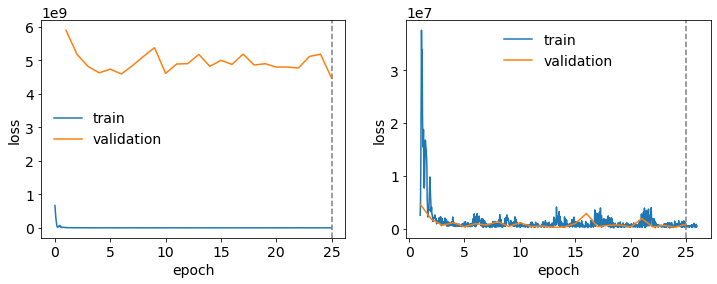

In [30]:
def counterfactual_fairness_reg(graph, model, X, Y, weight=1.):
    # Ignore X and Y, we'll create samples from the graph directly,
    # which gives us access to the latent variables that create them,
    # making training much faster.
    with torch.no_grad():
        sample, sample_d = graph.sample(X.size(0), return_all=True)
    
    # Get original prediction
    # First, we need to remove the cls columns from sample
    y_idx = graph.index('salary') # slice
    X = torch.cat([sample[:, :y_idx.start], sample[:, y_idx.stop:]], 1)
    
    original_pred = model(X)
    
    # Then, compute counterfactuals
    # If we are going to use the latents from the original sample,
    # we can only do 1 counterfactual per sample.
    # For our purposes, however, this is enough.
    
    # To create the counterfactual sample, 
    # we need to intervene on the desired attribute
    # AND on all the latent variables, with the value that we previously got.
    sample_d = { node: t for node, t in sample_d.items() if node.latent }
    # Add the desired intervention here
    sample_d['gender'] = 1 - sample[:, graph.index('gender')]
        
    # Compute counterfactuals
    with torch.no_grad():
        cf = graph.sample(X.size(0), interventions=sample_d)
        
    # cf contains Y, we need to remove it before passing it to the model
    cf = torch.cat([cf[:, :y_idx.start], cf[:, y_idx.stop:]], 1)
    cf_pred = model(cf)
    
    # Finally, compare both predictions with L2
    reg = weight * (cf_pred - original_pred) ** 2
    
    return reg

from functools import partial
reg = partial(counterfactual_fairness_reg, graph, weight=10.)

reg_model = train(trainX, trainY, valX, valY, reg=reg, lr=1e-2)

(0.6798765334376475, 0.8276005987262733)

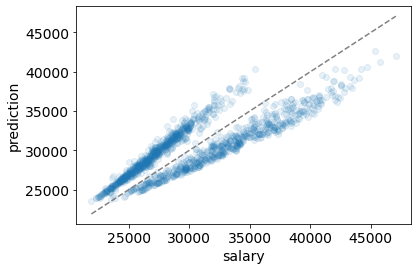

In [31]:
ytrue = test.salary
pred = pd.Series(reg_model.predict(test.drop('salary', 1)), index=ytrue.index)

plt.scatter(ytrue, pred, alpha=.1)
plt.xlabel('salary')
plt.ylabel('prediction')
m, M = min(ytrue.min(), pred.min()), max(ytrue.max(), pred.max())
plt.plot([m, M], [m, M], ls='--', color='gray')

# R2
metrics.r2_score(ytrue, pred), \
pd.DataFrame({'ytrue': ytrue, 'ypred': pred}).corr('spearman').iloc[0, 1]

In [32]:
pd.DataFrame({
    'gender': test.gender, 
    'ytrue': ytrue, 
    'ypred': pred
}).groupby('gender').apply(lambda subdf: subdf[['ytrue', 'ypred']].corr('spearman').iloc[0, 1])

gender
False    0.899937
True     0.892689
dtype: float64

(0.9848089078367231, 0.991135964690321)

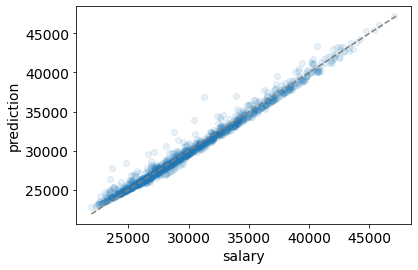

In [33]:
ytrue = test.salary
pred = pd.Series(model.predict(test.drop('salary', 1)), index=ytrue.index)

plt.scatter(ytrue, pred, alpha=.1)
plt.xlabel('salary')
plt.ylabel('prediction')
m, M = min(ytrue.min(), pred.min()), max(ytrue.max(), pred.max())
plt.plot([m, M], [m, M], ls='--', color='gray')

# R2
metrics.r2_score(ytrue, pred), \
pd.DataFrame({'ytrue': ytrue, 'ypred': pred}).corr('spearman').iloc[0, 1]

In [34]:
pd.DataFrame({
    'gender': test.gender, 
    'ytrue': ytrue, 
    'ypred': pred
}).groupby('gender').apply(lambda subdf: subdf[['ytrue', 'ypred']].corr('spearman').iloc[0, 1])

gender
False    0.988137
True     0.991733
dtype: float64

In [35]:
def counterfactual_fairness(graph, model, df):
    original_pred = model.predict(df.drop('salary', 1))
    X = torch.Tensor(df.values.astype(float)).to(device)
    X = graph.tensor_to_dict(X)
    X.pop(graph['salary'])
    
    with torch.no_grad():
        cf, w = graph.counterfactual(
            X, interventions=dict(gender=1 - X[graph['gender']]), 
            ex_n=100, agg=False
        )
        
    cf = cf.view(-1, cf.size(-1))
    df_cf = pd.DataFrame(cf.cpu().numpy(), columns=df.columns).drop('salary', 1)
    pred = torch.Tensor(model.predict(df_cf)).view(*w.shape).to(device)
    pred = (pred * w).sum(0).flatten().cpu().numpy()
    
    return np.abs(original_pred - pred).mean()

In [36]:
cff_reg = []

for _ in range(100):
    with torch.no_grad():
        cff_reg.append(counterfactual_fairness(graph, reg_model, test))
    
ci(cff_reg)

'233.565 +- 0.065'

In [37]:
cff_reg = []

for _ in range(100):
    with torch.no_grad():
        cff_reg.append(counterfactual_fairness(graph, model, test))
    
ci(cff_reg)

'3883.438 +- 1.097'

In [38]:
rf_model = RandomForestRegressor(n_estimators=100).fit(
    _train.drop('salary', 1),
    reg_model.predict(_train.drop('salary', 1))
)

In [39]:
pd.Series(rf_model.feature_importances_, index=[col for col in _train.columns if col != 'salary']).sort_values()

field        0.001303
gender       0.008850
age          0.030869
seniority    0.176865
education    0.782112
dtype: float64

We'll now take a sample, a woman with a particularly unfair salary (w.r.t. cf. fairness), and evaluate the effect of gender on her salary. Then, test our new fairer model on that woman.

In [40]:
original_preds = pd.Series(model.predict(_train.drop('salary', 1)), index=_train.index)
original_preds_fair = pd.Series(reg_model.predict(_train.drop('salary', 1)), index=_train.index)

In [41]:
np.random.seed(123)

samples_gender = _train[_train.gender == 0].sample(1000)

In [42]:
ex_n = 100

with torch.no_grad():
    X = torch.Tensor(samples_gender.astype(float).values).to(device)
    cf, w = graph.counterfactual(X, interventions={'gender': True}, ex_n=ex_n, agg=False)
    
    cf_exp = pd.DataFrame(
        (cf * w).sum(0).cpu().numpy(), 
        columns=_train.columns, index=samples_gender.index
    ).drop('salary', 1)
    
    cf_df = pd.DataFrame(cf.view(-1, cf.size(-1)).cpu().numpy(), columns=samples_gender.columns)
    cf_pred = model.predict(cf_df.drop('salary', 1))
    cf_pred = torch.Tensor(cf_pred).view(ex_n, len(X), 1).to(w.device)
    cf_pred = pd.Series((cf_pred * w).sum(0).cpu().numpy().flatten(), index=samples_gender.index)
    
    cf_pred_fair = reg_model.predict(cf_df.drop('salary', 1))
    cf_pred_fair = torch.Tensor(cf_pred_fair).view(ex_n, len(X), 1).to(w.device)
    cf_pred_fair = pd.Series((cf_pred_fair * w).sum(0).cpu().numpy().flatten(), index=samples_gender.index)

In [43]:
unfair_woman = idx = (cf_pred - original_preds).idxmax()

idx

4746

In [44]:
original_preds.loc[idx], cf_pred.loc[idx], original_preds_fair.loc[idx], cf_pred_fair.loc[idx]

(34551.1, 43076.99, 38960.11, 39378.64)

For the non-causal counterfactual, since gender didn't affect job and seniority, its predicted salary is extremely underestimated. In other words, by not accounting for the effect of the intervention on the rest of the variables, the prediction is not valid.

In [45]:
def parse(sample, node, add_p=False):
    sample = sample[graph.index(node)]
    
    if node.dim > 1:
        idx = sample.idxmax()
        return idx.replace(node.name + '_', '') + ' (%.3f)' % sample.loc[idx]
    else:
        return sample.iloc[0]

sample_parsed = pd.DataFrame({
    col: pd.Series(
        [
            parse(sample, node)
            for node in graph
            if not node.latent and node.name != 'salary'
        ], 
        index=[node.name for node in graph if not node.latent and node.name != 'salary']
    )
    
    for col, sample in zip(
        ['real', 'cf expectation'], 
        [samples_gender.loc[idx].drop('salary'), cf_exp.loc[idx]]
    )
})

# Note that salary here is the one proposed by the graph, not the model we're studying
sample_parsed 

real  cf expectation
gender        False        1.000000
field         False        0.780000
age         43.9864       43.986389
education  0.824632        0.824632
seniority   1.70006        2.234483